# **CVIII - 2022**

The code is open source so it can be used as an starting point for your personal projects (Ref-ISBN: 9781098102333)

##### **Dataset**
The dataset can be found and freely downloaded from the below bucket:

* gs://cloud-ml-data/img/flower_photos/train_set.csv
* gs://cloud-ml-data/img/flower_photos/eval_set.csv

# **Always Run The Below Cell**

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten
import matplotlib
import math, re, os, sys
import random
from google.colab import drive
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AABC')

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32

CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

all_flowers = tf.io.gfile.glob("flower_photos/*/*")

def read_reshape_img(filename, reshape_dims):
    img = tf.io.read_file(filename)
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

def decode_csv(row):
    cols = ["path", "flower"]
    filename, label = tf.io.decode_csv(records=row, record_defaults=cols)
    img = read_reshape_img(filename, [IMG_HEIGHT, IMG_WIDTH])
    # numerizing the label (not one-hot encode)
    # So the label is sparse
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label))
    return img, label

def show_single_image(filename):
    img = read_reshape_img(filename, [IMG_HEIGHT, IMG_WIDTH])
    print("Shape:", img.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow((img.numpy()));

def show_100_images(all_flowers):
  fig, axes = plt.subplots(10,10,figsize=(15,15))
  for i in range(10):
      for j in range(10):
          axes[i,j].set_xticks([])
          axes[i,j].set_yticks([])
          axes[i,j].spines['top'].set_visible(False)
          axes[i,j].spines['right'].set_visible(False)
          axes[i,j].spines['bottom'].set_visible(False)
          axes[i,j].spines['left'].set_visible(False)
          axes[i,j].imshow(read_reshape_img(all_flowers[random.randint(1, len(all_flowers))], [IMG_HEIGHT, IMG_WIDTH]))

def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

train_dataset = tf.data.TextLineDataset('train_set.csv').map(decode_csv).batch(BATCH_SIZE)
eval_dataset = tf.data.TextLineDataset('eval_set.csv').map(decode_csv).batch(BATCH_SIZE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **The training function**

In [ ]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16,
                       epochs=5, 
                       fineTune = False):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset("train_set.csv").map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset("eval_set.csv").map(decode_csv)).batch(32) # this doesn't matter

  layers = [
      # Adding MobileNet V3 from tensorflow hub
      hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5", 
                     input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                     trainable=fineTune, # if fineTune = True then we use train on the pretrained network with it's weights as the initial values 
                     name='mobilenet_V3_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation='relu',
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  ]

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=epochs)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_V3_embedding (Ker  (None, 1280)             4226432   
 asLayer)                                                        
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 4,247,013
Trainable params: 20,581
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/5
104/104 [==============================] - 87s 696ms/step - loss: 0.5356 - accuracy: 0.8027 - val_loss: 0.3151 - val_accuracy: 0.8946
Epoch 2/5
104/104 [==============================] - 65s 626ms/step - loss: 0.2

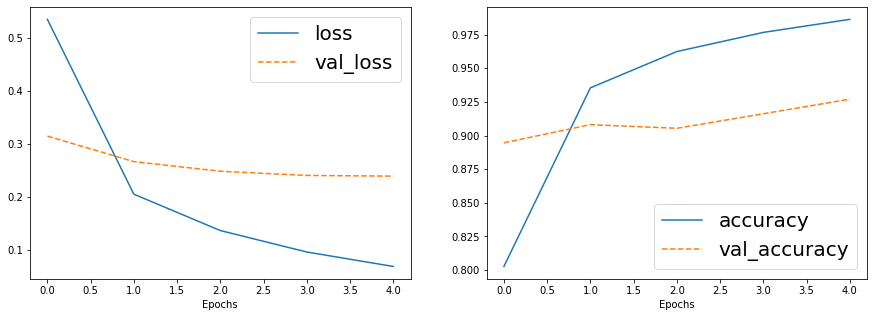

In [ ]:
model = train_and_evaluate()

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_V3_embedding (Ker  (None, 1280)             4226432   
 asLayer)                                                        
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 4,247,013
Trainable params: 20,581
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 60s 540ms/step - loss: 0.5577 - accuracy: 0.8006 - val_loss: 0.3097 - val_accuracy: 0.8919
Epoch 2/10
104/104 [==============================] - 51s 488ms/step - loss: 0

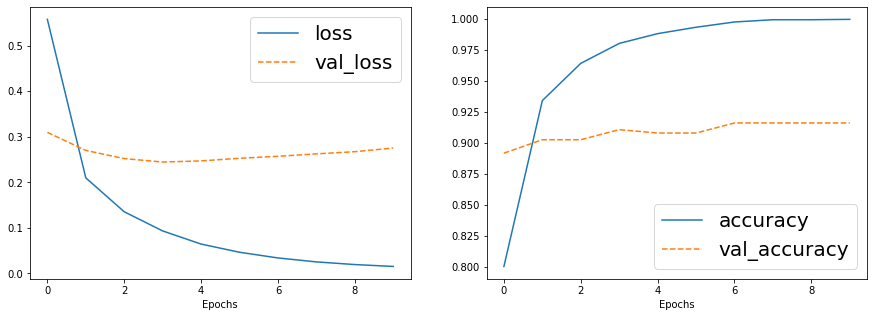

In [ ]:
model2 = train_and_evaluate(epochs=10)

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_V3_embedding (Ker  (None, 1280)             4226432   
 asLayer)                                                        
                                                                 
 dense_hidden (Dense)        (None, 256)               327936    
                                                                 
 flower_prob (Dense)         (None, 5)                 1285      
                                                                 
Total params: 4,555,653
Trainable params: 329,221
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/5
104/104 [==============================] - 51s 452ms/step - loss: 0.3535 - accuracy: 0.8676 - val_loss: 0.2764 - val_accuracy: 0.9054
Epoch 2/5
104/104 [==============================] - 47s 448ms/step - loss: 0.

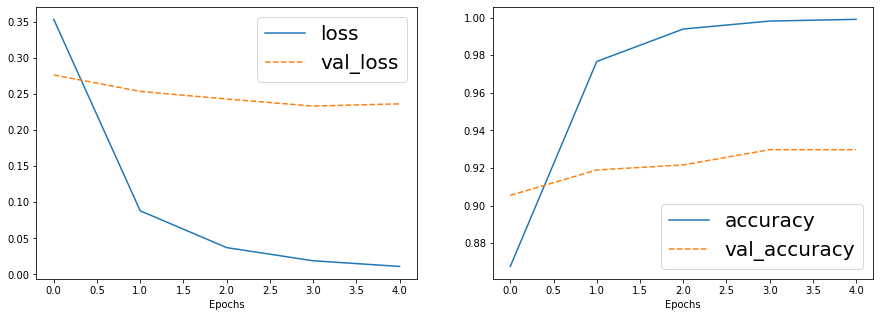

In [ ]:
model3 = train_and_evaluate(num_hidden=256,epochs=5)

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_V3_embedding (Ker  (None, 1280)             4226432   
 asLayer)                                                        
                                                                 
 dense_hidden (Dense)        (None, 256)               327936    
                                                                 
 flower_prob (Dense)         (None, 5)                 1285      
                                                                 
Total params: 4,555,653
Trainable params: 329,221
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 52s 464ms/step - loss: 0.3669 - accuracy: 0.8627 - val_loss: 0.3035 - val_accuracy: 0.9162
Epoch 2/10
104/104 [==============================] - 54s 524ms/step - loss: 

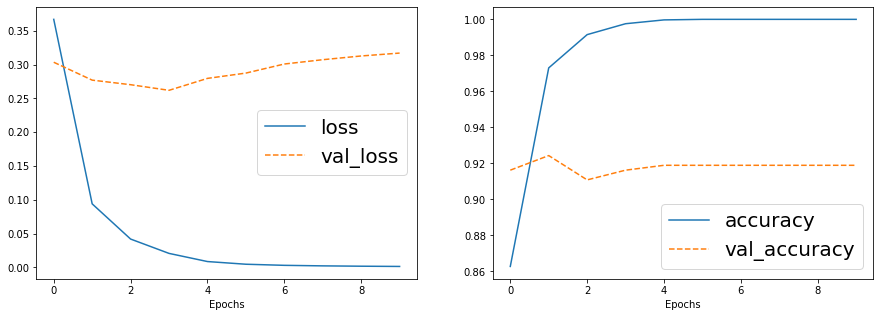

In [ ]:
model4 = train_and_evaluate(num_hidden=256,epochs=10)

# **Fine Tuning**
The models aboove do not train on the pretrained layers.

We might get better results if we adapt the pretrained layers (**This is called Fine Tuning**)

In this method we used the pretrained weights as the initial values for the neural network (Instead of random initialisation)

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_V3_embedding (Ker  (None, 1280)             4226432   
 asLayer)                                                        
                                                                 
 dense_hidden (Dense)        (None, 256)               327936    
                                                                 
 flower_prob (Dense)         (None, 5)                 1285      
                                                                 
Total params: 4,555,653
Trainable params: 329,221
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/5
104/104 [==============================] - 571s 5s/step - loss: 0.3538 - accuracy: 0.8703 - val_loss: 0.2711 - val_accuracy: 0.9135
Epoch 2/5
104/104 [==============================] - 445s 4s/step - loss: 0.0864

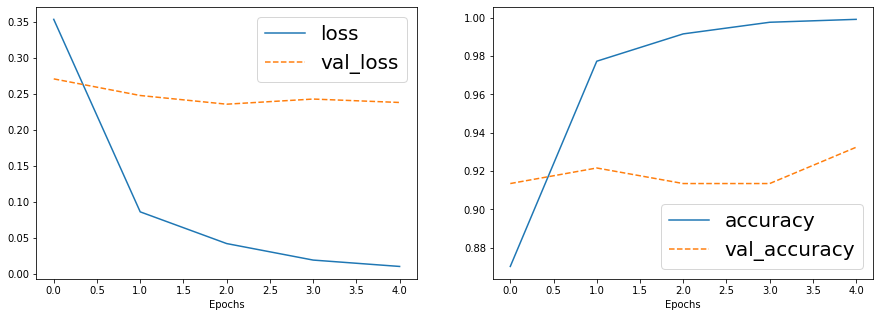

In [ ]:
# Just Fine tuning on the best results from above for Mobilenet V3
model5 = train_and_evaluate(num_hidden=256,epochs=5, fineTune=True)

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_V3_embedding (Ker  (None, 1280)             4226432   
 asLayer)                                                        
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 4,247,013
Trainable params: 20,581
Non-trainable params: 4,226,432
_________________________________________________________________
None
Epoch 1/5
104/104 [==============================] - 271s 3s/step - loss: 0.5036 - accuracy: 0.8297 - val_loss: 0.3227 - val_accuracy: 0.8919
Epoch 2/5
104/104 [==============================] - 232s 2s/step - loss: 0.2078 

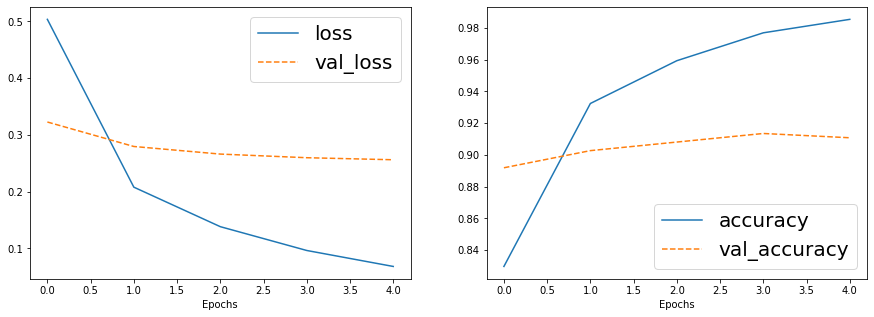

In [ ]:
# Just Fine tuning on only 16 hidden neurons Mobilenet V3
model5 = train_and_evaluate(num_hidden=16,epochs=5, fineTune=True)

# Notice
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.